# Local Search for Traveling Salesman Problem

---

**Traveling Salesman Problem (TSP)** is a very well known combinatorial optimisation problem with many real-world applications in logistics and delivery indutries.

In [3]:
def load_data(file):

    """
    Read a TSP instance from a .tsp file, and returns the coordinates of the points.

    :param file: the .tsp file.
    :return: coord
    """

    f = open(file, "r")
    
    # Skip the first information rows until "NODE_COORD_SECTION" is seen
    line = f.readline()
    while not line.__contains__("NODE_COORD_SECTION"):
        line = f.readline()

    # Read the coordinate section
    coord = {}

    line = f.readline()
    while not line.__contains__("EOF"):
        line_elements = line.split()
        id = int(line_elements[0])
        x = float(line_elements[1])
        y = float(line_elements[2])
        coord[id] = [x, y]
        line = f.readline()

    f.close()

    return coord

In [4]:
coord = load_data("data/a280.tsp")

# for id in coord.keys():
#     print(f"{id}: [{coord[id][0]}, {coord[id][1]}]")

In [5]:
import numpy as np
import math

def euclidean_distance_matrix(coord):
    """
    Calculate the Euclidean distance matrix based on the coordinates.
    """
    
    id_list = list(coord.keys())
    
    dist_mtx = np.zeros((max(id_list)+1, max(id_list)+1))
    for id1 in coord.keys():
        [x1, y1] = coord[id1]
        for id2 in coord.keys():
            if id1 == id2:
                continue
            
            [x2, y2] = coord[id2]
            dist = round(math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)))
            dist_mtx[id1, id2] = dist
    
    return dist_mtx

In [6]:
dist_mtx = euclidean_distance_matrix(coord)

print(dist_mtx)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 20. ... 43. 34. 18.]
 [ 0. 20.  0. ... 36. 28.  9.]
 ...
 [ 0. 43. 36. ...  0.  9. 29.]
 [ 0. 34. 28. ...  9.  0. 20.]
 [ 0. 18.  9. ... 29. 20.  0.]]


In [7]:
def load_tour(file):

    """
    Read a TSP tour from a .tour file.

    :param file: the .tour file.
    :return: The TSP solution, which is an array of nodes.
    """

    f = open(file, "r")

    tour = []
    line = f.readline()
    while not line.__contains__("TOUR_SECTION"):
        line = f.readline()
        
    line = f.readline()
    while not line.__contains__("-1"):
        id = int(line)
        tour.append(id)
        line = f.readline()

    f.close()
    
    # Add the first node to the end to form a cycle
    tour.append(tour[0])

    return np.array(tour)

In [8]:
def calc_tour_cost(tour, dist_mtx):
    return sum([dist_mtx[tour[i], tour[i+1]] for i in range(len(tour)-1)])

In [9]:
import matplotlib.pyplot as plt

def visualise(tour, coord, title):
    """
    Function for visualise a TSP tour on a 2D figure.

    :param tour: The TSP tour, which is a list of nodes.
    :param coord: Dictionary of {id: [x, y]} coordinates for each node.
    :param title: Plot title.
    """
    
    px = [coord[id][0] for id in coord.keys()]
    py = [coord[id][1] for id in coord.keys()]

    # Set axis too slightly larger than the set of x and y
    min_x, max_x, min_y, max_y = min(px), max(px), min(py), max(py)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    width = (max(px) - min(px)) * 1.1
    height = (max(py) - min(py)) * 1.1

    min_x = center_x - width / 2
    max_x = center_x + width / 2
    min_y = center_y - height / 2
    max_y = center_y + height / 2

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    
    # Plot the [px, py] points
    for [x, y] in coord.values():
        plt.plot(x, y, 'co', markersize = 5)
    
    # Plot the tour
    for i in range(0, len(tour)-1):
        [x1, y1], [x2, y2] = coord[tour[i]], coord[tour[i + 1]]
        plt.plot([x1, x2], [y1, y2], color = 'c')

    plt.title(title)
    plt.show()

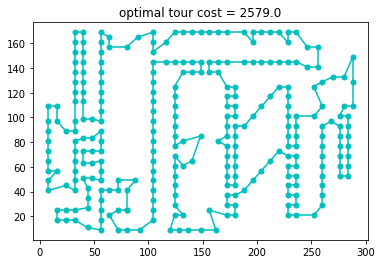

In [10]:
opt_tour = load_tour("data/a280.opt.tour")
opt_tc = calc_tour_cost(opt_tour, dist_mtx)
visualise(opt_tour, coord, "optimal tour cost = " + str(opt_tc))

In [32]:
def random_tour(coord, seed):
    node_ids = np.array(list(coord.keys()))
    rand_tour = np.copy(node_ids)
    np.random.seed(seed)
    np.random.shuffle(rand_tour)

    rand_tour = np.append(rand_tour, rand_tour[0])

    return rand_tour

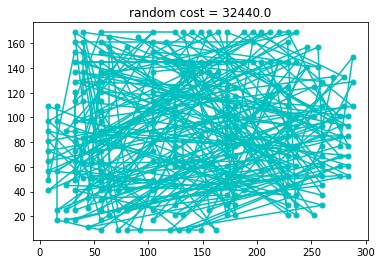

In [33]:
rand_tour = random_tour(coord, 10)
cost = calc_tour_cost(rand_tour, dist_mtx)
visualise(rand_tour, coord, "random cost = " + str(cost))

In [19]:
def two_opt_best_improvement(tour, dist_mtx):
    best_change = 0
    best_i = None
    best_j = None
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = dist_mtx[n1, n2] + dist_mtx[n3, n4] - dist_mtx[n1, n3] - dist_mtx[n2, n4]

        if cost_change > best_change:
            best_change = cost_change
            best_i = 0
            best_j = j
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = dist_mtx[n1, n2] + dist_mtx[n3, n4] - dist_mtx[n1, n3] - dist_mtx[n2, n4]
            
            if cost_change > best_change:
                best_change = cost_change
                best_i = i
                best_j = j
    
    return best_change, best_i, best_j

In [14]:
import time

log = [] # The log [time, cost]
start = time.time()

tour = random_tour(coord, 1)
cost = calc_tour_cost(tour, dist_mtx)

end = time.time()
log.append([end-start, cost])

improved = True
while improved:
    improved = False
    
    best_change, best_i, best_j = two_opt_best_improvement(tour, dist_mtx)
    
    # Actually change the tour if we found an improvement
    if best_change > 0.0000000001:
        # Change the tour, reverse the part [best_i+1, best_j]
        tour[best_i+1:best_j+1] = tour[best_i+1:best_j+1][::-1]
        cost -= best_change
        improved = True
    
    end = time.time()
    log.append([end-start, cost])

print(f"{end - start} seconds elapsed.")

visualise(tour, coord, "")

# Plot the [px, py] points
for [t, cost] in log:
    plt.plot(t, cost, 'co', markersize = 2)
plt.title("final cost = " + str(cost))

NameError: name 'random_tour' is not defined

In [16]:
def two_opt_first_improvement(tour, dist_mtx):
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = dist_mtx[n1, n2] + dist_mtx[n3, n4] - dist_mtx[n1, n3] - dist_mtx[n2, n4]

        if cost_change > 0.0000000001:
            return cost_change, 0, j
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = dist_mtx[n1, n2] + dist_mtx[n3, n4] - dist_mtx[n1, n3] - dist_mtx[n2, n4]
            
            if cost_change > 0.0000000001:
                return cost_change, i, j
    
    return 0, None, None

11.605356931686401 seconds elapsed.


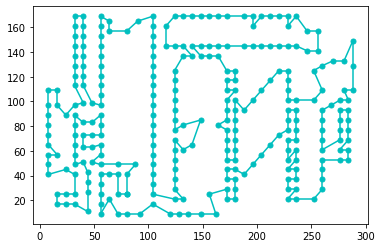

Text(0.5, 1.0, 'final cost = 2674.0')

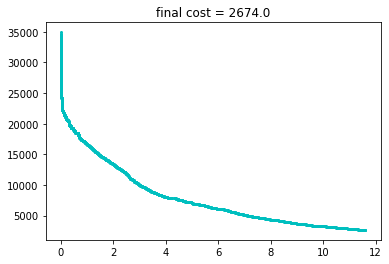

In [42]:
log = [] # The log [time, cost]
start = time.time()

tour = random_tour(coord, 1)
cost = calc_tour_cost(tour, dist_mtx)

end = time.time()
log.append([end-start, cost])

improved = True
while improved:
    improved = False
    
    best_change, best_i, best_j = two_opt_first_improvement(tour, dist_mtx)
    
    # Actually change the tour if we found an improvement
    if best_change > 0.0000000001:
        # Change the tour, reverse the part [best_i+1, best_j]
        tour[best_i+1:best_j+1] = tour[best_i+1:best_j+1][::-1]
        cost -= best_change
        improved = True
        
    end = time.time()
    log.append([end-start, cost])

print(f"{end - start} seconds elapsed.")

visualise(tour, coord, "")

# Plot the [px, py] points
for [t, cost] in log:
    plt.plot(t, cost, 'co', markersize = 2)
plt.title("final cost = " + str(cost))

In [11]:
def nearest_neighbour_tsp(node_ids, dist_mtx):
    '''
    The nearest neighbour heuristic to solve TSP.
    '''    
    # Arbitrarily select the first node as the start node
    start_node = node_ids[0]
    tour = [start_node]
    remaining_nodes = list(node_ids[1:])
    
    while len(remaining_nodes) > 0:
        curr_node = tour[-1]
        min_dist = float('inf')
        
        for node in remaining_nodes:
            if node == curr_node:
                continue
            
            # Find the nearest neighbour with the min cost from curr_node
            if dist_mtx[curr_node, node] < min_dist:
                next_node = node
                min_dist = dist_mtx[curr_node, node]

        tour.append(next_node)
        remaining_nodes.remove(next_node)
    
    tour.append(start_node)
    
    return np.array(tour)

In [12]:
nn_tour = nearest_neighbour_tsp(list(coord.keys()), dist_mtx)

0.537003755569458 seconds elapsed.


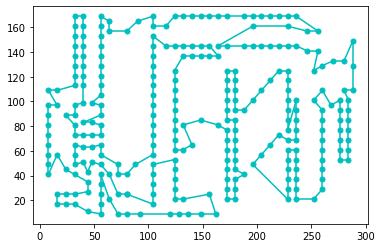

Text(0.5, 1.0, 'final cost = 2767.0')

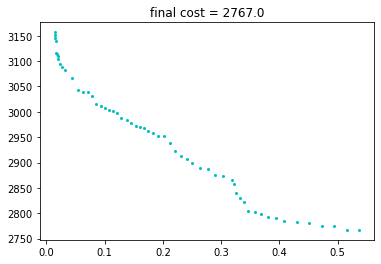

In [21]:
log = [] # The log [time, cost]
start = time.time()

tour = nearest_neighbour_tsp(list(coord.keys()), dist_mtx)
cost = calc_tour_cost(tour, dist_mtx)

end = time.time()
log.append([end-start, cost])

improved = True
while improved:
    improved = False
    
    best_change, best_i, best_j = two_opt_first_improvement(tour, dist_mtx)
    
    # Actually change the tour if we found an improvement
    if best_change > 0.0000000001:
        # Change the tour, reverse the part [best_i+1, best_j]
        tour[best_i+1:best_j+1] = tour[best_i+1:best_j+1][::-1]
        cost -= best_change
        improved = True
        
    end = time.time()
    log.append([end-start, cost])

print(f"{end - start} seconds elapsed.")

visualise(tour, coord, "")

# Plot the [px, py] points
for [t, cost] in log:
    plt.plot(t, cost, 'co', markersize = 2)
plt.title("final cost = " + str(cost))

---

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)